In [75]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

### 6.1 The next differential equation
$$ \frac{\mathrm{d}y}{\mathrm{d}x} = \frac{1}{\sigma^2}(x_0-x)y $$
$$ \left(\frac{\mathrm{d}y}{\mathrm{d}x}\right)^2 = \frac{\mathrm{d}^2y}{\mathrm{d}x^2}y + \frac{1}{\sigma^2}y^2 $$

### 6.2 First-order differential equation
a) Solve the above first-order differential equation with neural network models of varying widths and depths of feed forward linear layers with activation. Perhaps also investigate the range of $x$-values for which the model is trained. Use $(1,1)$ as a boundary condition.

In [76]:
class PhysicsInformed(nn.Module):
    def __init__(self, N_hidden_depth=2, N_hidden_width=8):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, N_hidden_width),
            nn.SiLU(),
            *[action for action_pair in \
              [(nn.Linear(N_hidden_width, N_hidden_width), nn.SiLU(),) for _ in range(N_hidden_depth - 1)] \
              for action in action_pair],
            nn.Linear(N_hidden_width, 1))
        self.N_epochs_trained = 0
    
    def forward(self, x):
        return self.layers(x)
    
    def prediction_and_derivative(self, x):
        prediction = self.forward(x)
        derivative = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0]
        return prediction, derivative

In [77]:
def train(model, x0, y0_target, criterion, optimizer, epochs=2500, xmin=-5, xmax=5):
    x0 = torch.tensor(x0, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    y0_target = torch.tensor(y0_target, dtype=torch.float32).reshape(-1, 1)

    for epoch in tqdm(range(epochs), desc=f'Training {model.__class__.__name__}'):
        xs = torch.rand((32, 1), requires_grad=True) * (xmax - xmin) + xmin
        y, dydx = model.prediction_and_derivative(xs)
        loss = criterion(dydx, y*(1-xs)/0.5**2)

        y0_predicted, _ = model.prediction_and_derivative(x0)
        loss += criterion(y0_predicted, y0_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.N_epochs_trained += 1

Training with 1000 and 2000 epochs.

Training PhysicsInformed: 100%|██████████| 1000/1000 [00:01<00:00, 585.11it/s]


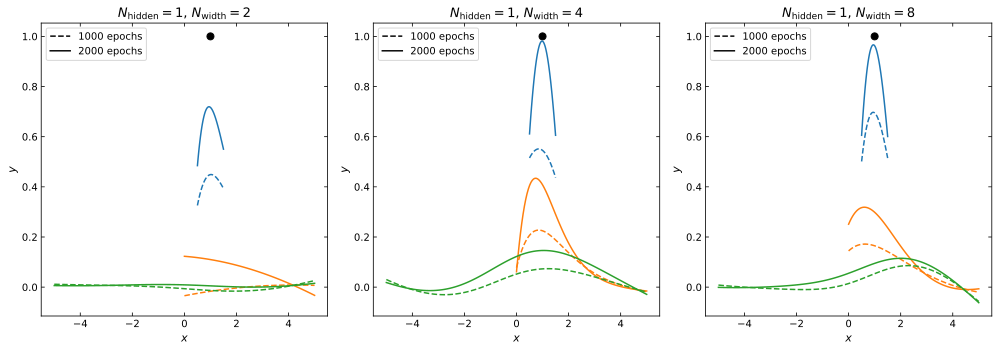

In [78]:
from matplotlib.lines import Line2D
criterion = nn.MSELoss()
x0 = 1
y0_target = 1
N_hidden_depth = 1
training_epochs = 1000
legend_handles = [
    Line2D([0], [0], color='black', linestyle='--', label=f'{training_epochs} epochs'),
    Line2D([0], [0], color='black', linestyle='-', label=f'{2*training_epochs} epochs')
]

# Three graphs with varying hidden layer widths
# Each graph has three x-ranges
# Each x-range has two numbers of training epochs

hidden_widths = [2, 4, 8]
domains = [[0.5, 1.5], [0, 5], [-5, 5]]

fig, axes = plt.subplots(1, 3, figsize=(14,5))
for ax, N_hidden_width in zip(axes, hidden_widths):
    for i, domain in enumerate(domains):
        model = PhysicsInformed(N_hidden_depth, N_hidden_width)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        
        train(model, x0, y0_target, criterion, optimizer, training_epochs, *domain)
        xs = torch.linspace(*domain, 100).reshape(-1, 1)
        ys = model(xs)
        ax.plot(xs.detach(), ys.detach(), label=f'{model.N_epochs_trained} epochs', c=f'C{i}', ls='--')

        train(model, x0, y0_target, criterion, optimizer, training_epochs, *domain)
        ys = model(xs)
        ax.plot(xs.detach(), ys.detach(), label=f'{model.N_epochs_trained} epochs', c=f'C{i}', ls='-')

    ax.scatter(x0, y0_target, c='k', s=50)

    ax.set(
        title=fr'$N_{{\mathrm{{hidden}}}} = {N_hidden_depth}$, $N_{{\mathrm{{width}}}} = {N_hidden_width}$',
        xlabel='$x$', ylabel='$y$',
    )
    ax.legend(handles=legend_handles, loc='upper left')

y_min = min(ax.get_ylim()[0] for ax in axes)
y_max = max(ax.get_ylim()[1] for ax in axes)
for ax in axes:
    ax.set_ylim(y_min, y_max)

plt.tight_layout()

fig.savefig('ex65_fig1.png')

Training with 10000 and 20000 epochs.

Training PhysicsInformed: 100%|██████████| 10000/10000 [00:12<00:00, 769.83it/s]


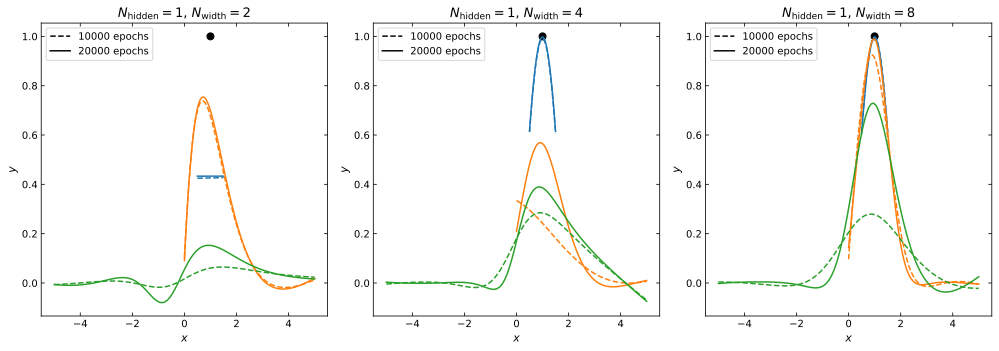

In [79]:
criterion = nn.MSELoss()
x0 = 1
y0_target = 1
N_hidden_depth = 1
training_epochs = 10000
legend_handles = [
    Line2D([0], [0], color='black', linestyle='--', label=f'{training_epochs} epochs'),
    Line2D([0], [0], color='black', linestyle='-', label=f'{2*training_epochs} epochs')
]

# Three graphs with varying hidden layer widths
# Each graph has three x-ranges
# Each x-range has two numbers of training epochs

hidden_widths = [2, 4, 8]
domains = [[0.5, 1.5], [0, 5], [-5, 5]]

fig, axes = plt.subplots(1, 3, figsize=(14,5))
for ax, N_hidden_width in zip(axes, hidden_widths):
    for i, domain in enumerate(domains):
        model = PhysicsInformed(N_hidden_depth, N_hidden_width)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        
        train(model, x0, y0_target, criterion, optimizer, training_epochs, *domain)
        xs = torch.linspace(*domain, 100).reshape(-1, 1)
        ys = model(xs)
        ax.plot(xs.detach(), ys.detach(), label=f'{model.N_epochs_trained} epochs', c=f'C{i}', ls='--')

        train(model, x0, y0_target, criterion, optimizer, training_epochs, *domain)
        ys = model(xs)
        ax.plot(xs.detach(), ys.detach(), label=f'{model.N_epochs_trained} epochs', c=f'C{i}', ls='-')

    ax.scatter(x0, y0_target, c='k', s=50)

    ax.set(
        title=fr'$N_{{\mathrm{{hidden}}}} = {N_hidden_depth}$, $N_{{\mathrm{{width}}}} = {N_hidden_width}$',
        xlabel='$x$', ylabel='$y$',
    )
    ax.legend(handles=legend_handles, loc='upper left')

y_min = min(ax.get_ylim()[0] for ax in axes)
y_max = max(ax.get_ylim()[1] for ax in axes)
for ax in axes:
    ax.set_ylim(y_min, y_max)

plt.tight_layout()

fig.savefig('ex65_fig2.png')

### 6.3 Second-order differential equation
Now solve the above second-order differential equation with neural network models of varying widths and depths of feed forward linear layers with activation.

In [80]:
class PhysicsInformed2ndOrder(PhysicsInformed):
    def prediction_derivative_and_2nd_derivative(self, x):
        prediction = self.forward(x)
        derivative = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0]
        second_derivative = torch.autograd.grad(derivative, x, torch.ones_like(derivative), create_graph=True)[0]
        return prediction, derivative, second_derivative

In [81]:
def train_2nd_order(model, x0y0_target, x0dy0dx_target, criterion, optimizer, epochs=2500, xmin=-5, xmax=5):
    x0 = [p[0] for p in x0y0_target]
    y0_target = [p[1] for p in x0y0_target]
    x0_for_y0 = torch.tensor(x0, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    y0_target = torch.tensor(y0_target, dtype=torch.float32).reshape(-1, 1)

    x0 = [p[0] for p in x0dy0dx_target]
    dy0dx_target = [p[1] for p in x0dy0dx_target]
    x0_for_dy0dx = torch.tensor(x0, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    dy0dx_target = torch.tensor(dy0dx_target, dtype=torch.float32).reshape(-1, 1)

    for epoch in tqdm(range(epochs), desc=f'Training {model.__class__.__name__}'):
        xs = torch.rand((32, 1), requires_grad=True) * (xmax - xmin) + xmin

        y, dydx, d2ydx2 = model.prediction_derivative_and_2nd_derivative(xs)
        loss = criterion(dydx**2, d2ydx2*y + 1/0.5**2*y**2)

        if len(x0_for_y0) > 0:
            y0_predicted = model.forward(x0_for_y0)
            loss += criterion(y0_predicted, y0_target)

        if len(x0_for_dy0dx) > 0:
            _, dy0dx_predicted, _ = model.prediction_derivative_and_2nd_derivative(x0_for_dy0dx)
            loss += criterion(dy0dx_predicted, dy0dx_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.N_epochs_trained += 1

Training PhysicsInformed2ndOrder: 100%|██████████| 10000/10000 [00:16<00:00, 591.44it/s]


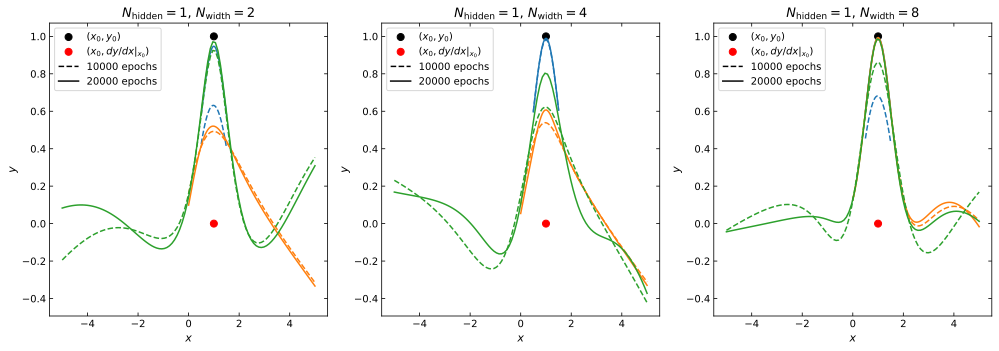

In [82]:
criterion = nn.MSELoss()
x0y0_target = [(1, 1)]
x0dy0dx_target = [(1, 0)]
N_hidden_depth = 1
training_epochs = 10000
custom_handles = [
    Line2D([0], [0], color='black', linestyle='--', label=f'{training_epochs} epochs'),
    Line2D([0], [0], color='black', linestyle='-', label=f'{2*training_epochs} epochs')
]

# Three graphs with varying hidden layer widths
# Each graph has three x-ranges
# Each x-range has two numbers of training epochs

hidden_widths = [2, 4, 8]
domains = [[0.5, 1.5], [0, 5], [-5, 5]]

fig, axes = plt.subplots(1, 3, figsize=(14,5))
for ax, N_hidden_width in zip(axes, hidden_widths):
    for i, domain in enumerate(domains):
        model = PhysicsInformed2ndOrder(N_hidden_depth, N_hidden_width)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        
        train_2nd_order(model, x0y0_target, x0dy0dx_target, criterion, optimizer, training_epochs, *domain)
        xs = torch.linspace(*domain, 100).reshape(-1, 1)
        ys = model(xs)
        ax.plot(xs.detach(), ys.detach(), c=f'C{i}', ls='--')

        train_2nd_order(model, x0y0_target, x0dy0dx_target, criterion, optimizer, training_epochs, *domain)
        ys = model(xs)
        ax.plot(xs.detach(), ys.detach(), c=f'C{i}', ls='-')

    ax.scatter(*zip(*x0y0_target), c='k', s=50, label='$(x_0, y_0)$')
    ax.scatter(*zip(*x0dy0dx_target), c='r', s=50, label='$(x_0, dy/dx|_{x_0})$')

    ax.set(
        title=fr'$N_{{\mathrm{{hidden}}}} = {N_hidden_depth}$, $N_{{\mathrm{{width}}}} = {N_hidden_width}$',
        xlabel='$x$', ylabel='$y$',
    )
    handles, labels = ax.get_legend_handles_labels()
    combined_handles = handles + custom_handles
    combined_labels = labels + [h.get_label() for h in custom_handles]
    ax.legend(combined_handles, combined_labels, loc='upper left')

y_min = min(ax.get_ylim()[0] for ax in axes)
y_max = max(ax.get_ylim()[1] for ax in axes)
for ax in axes:
    ax.set_ylim(y_min, y_max)

plt.tight_layout()

fig.savefig('ex65_fig3.png')

c) Now, train for more epochs over the proper $x$-range and plot the residual, which is difference between the left and right hand side of the differential equation

In [83]:
def get_residuals(model, xmin=-5, xmax=5):
    xs = torch.linspace(xmin, xmax, 100, requires_grad=True).reshape(-1, 1)
    y, dydx, d2ydx2 = model.prediction_derivative_and_2nd_derivative(xs)
    residuals = dydx**2 - d2ydx2*y - 1/0.5**2*y**2
    return xs, residuals

Training PhysicsInformed2ndOrder:   0%|          | 0/10000 [00:00<?, ?it/s]

Training PhysicsInformed2ndOrder: 100%|██████████| 10000/10000 [00:17<00:00, 586.46it/s]


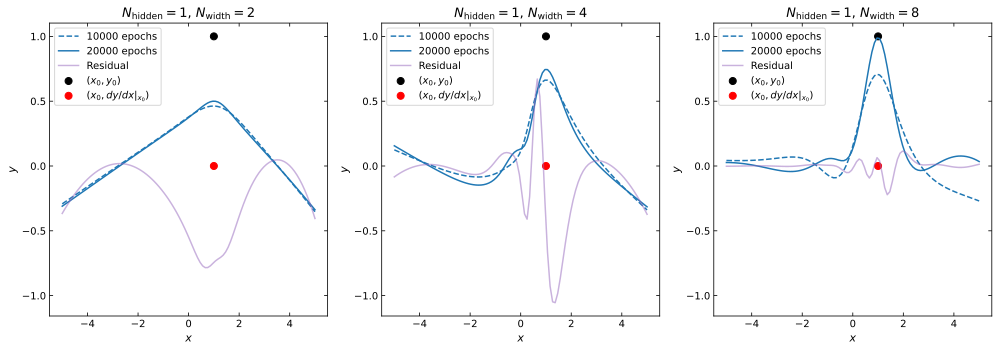

In [84]:
criterion = nn.MSELoss()
x0y0_target = [(1, 1)]
x0dy0dx_target = [(1, 0)]
N_hidden_depth = 1
training_epochs = 10000

# Three graphs with varying hidden layer widths
# Each graph has three x-ranges
# Each x-range has two numbers of training epochs

hidden_widths = [2, 4, 8]
domain = [-5, 5]

fig, axes = plt.subplots(1, 3, figsize=(14,5))
for ax, N_hidden_width in zip(axes, hidden_widths):
    model = PhysicsInformed2ndOrder(N_hidden_depth, N_hidden_width)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    
    train_2nd_order(model, x0y0_target, x0dy0dx_target, criterion, optimizer, training_epochs, *domain)
    xs = torch.linspace(*domain, 100).reshape(-1, 1)
    ys = model(xs)
    ax.plot(xs.detach(), ys.detach(), c=f'C0', ls='--', label=f'{model.N_epochs_trained} epochs')

    train_2nd_order(model, x0y0_target, x0dy0dx_target, criterion, optimizer, training_epochs, *domain)
    ys = model(xs)
    ax.plot(xs.detach(), ys.detach(), c=f'C0', ls='-', label=f'{model.N_epochs_trained} epochs')

    xs, residuals = get_residuals(model, *domain)
    ax.plot(xs.detach(), residuals.detach(), c='C4', ls='-', label='Residual', alpha=0.5)

    ax.scatter(*zip(*x0y0_target), c='k', s=50, label='$(x_0, y_0)$')
    ax.scatter(*zip(*x0dy0dx_target), c='r', s=50, label='$(x_0, dy/dx|_{x_0})$')

    ax.set(
        title=fr'$N_{{\mathrm{{hidden}}}} = {N_hidden_depth}$, $N_{{\mathrm{{width}}}} = {N_hidden_width}$',
        xlabel='$x$', ylabel='$y$',
    )
    ax.legend(loc='upper left')

y_min = min(ax.get_ylim()[0] for ax in axes)
y_max = max(ax.get_ylim()[1] for ax in axes)
for ax in axes:
    ax.set_ylim(y_min, y_max)

plt.tight_layout()

fig.savefig('ex65_fig4.png')

Training PhysicsInformed2ndOrder: 100%|██████████| 10000/10000 [00:29<00:00, 343.59it/s]


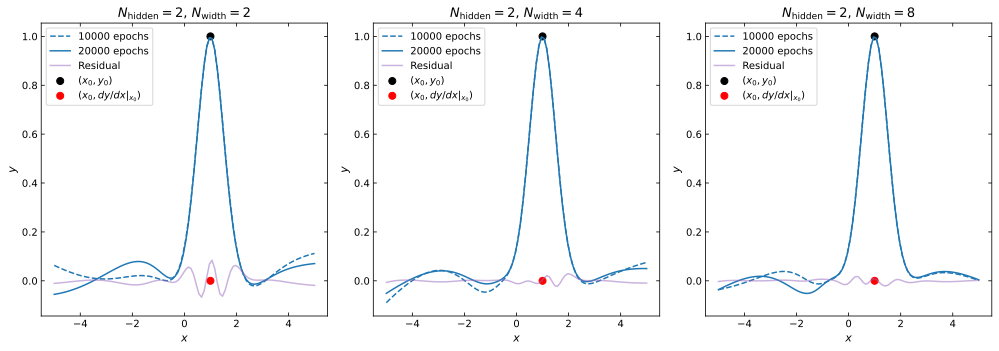

In [85]:
criterion = nn.MSELoss()
x0y0_target = [(1, 1)]
x0dy0dx_target = [(1, 0)]
N_hidden_depth = 2
training_epochs = 10000

# Three graphs with varying hidden layer widths
# Each graph has three x-ranges
# Each x-range has two numbers of training epochs

hidden_widths = [2, 4, 8]
domain = [-5, 5]

fig, axes = plt.subplots(1, 3, figsize=(14,5))
for ax, N_hidden_width in zip(axes, hidden_widths):
    model = PhysicsInformed2ndOrder(N_hidden_depth, N_hidden_width)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    
    train_2nd_order(model, x0y0_target, x0dy0dx_target, criterion, optimizer, training_epochs, *domain)
    xs = torch.linspace(*domain, 100).reshape(-1, 1)
    ys = model(xs)
    ax.plot(xs.detach(), ys.detach(), c=f'C0', ls='--', label=f'{model.N_epochs_trained} epochs')

    train_2nd_order(model, x0y0_target, x0dy0dx_target, criterion, optimizer, training_epochs, *domain)
    ys = model(xs)
    ax.plot(xs.detach(), ys.detach(), c=f'C0', ls='-', label=f'{model.N_epochs_trained} epochs')

    xs, residuals = get_residuals(model, *domain)
    ax.plot(xs.detach(), residuals.detach(), c='C4', ls='-', label='Residual', alpha=0.5)

    ax.scatter(*zip(*x0y0_target), c='k', s=50, label='$(x_0, y_0)$')
    ax.scatter(*zip(*x0dy0dx_target), c='r', s=50, label='$(x_0, dy/dx|_{x_0})$')

    ax.set(
        title=fr'$N_{{\mathrm{{hidden}}}} = {N_hidden_depth}$, $N_{{\mathrm{{width}}}} = {N_hidden_width}$',
        xlabel='$x$', ylabel='$y$',
    )
    ax.legend(loc='upper left')

y_min = min(ax.get_ylim()[0] for ax in axes)
y_max = max(ax.get_ylim()[1] for ax in axes)
for ax in axes:
    ax.set_ylim(y_min, y_max)

plt.tight_layout()

fig.savefig('ex65_fig5.png')